# Vision Transformer from scratch

<img src="https://github.com/lucidrains/vit-pytorch/raw/main/images/vit.gif">



**Implementation of [Vision Transformer](https://arxiv.org/abs/2010.11929) from scratch with tensorflow** 








**An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale**

> While the Transformer architecture has become the de-facto standard for natural language processing tasks, its applications to computer vision remain limited. In vision, attention is either applied in conjunction with convolutional networks, or used to replace certain components of convolutional networks while keeping their overall structure in place. We show that this reliance on CNNs is not necessary and a pure transformer applied directly to sequences of image patches can perform very well on image classification tasks. When pre-trained on large amounts of data and transferred to multiple mid-sized or small image recognition benchmarks (ImageNet, CIFAR-100, VTAB, etc.), Vision Transformer (ViT) attains excellent results compared to state-of-the-art convolutional networks while requiring substantially fewer computational resources to train.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 

2022-04-05 09:41:23.810539: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


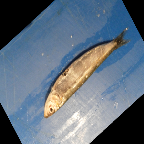

In [2]:
image=tf.keras.preprocessing.image.load_img('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00001.png', target_size=(144 , 144))
image

In [3]:
imageArray=tf.keras.preprocessing.image.img_to_array(image)

In [4]:
imageArray = imageArray[tf.newaxis , ...]
print(imageArray.shape)

(1, 144, 144, 3)


In [5]:
patches= tf.image.extract_patches(imageArray, sizes=[1 , 16 , 16 ,1], strides=[1 , 16 ,16 , 1] , rates=[1,1,1,1], padding="VALID" )

2022-04-05 09:41:28.129071: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-05 09:41:28.134032: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-05 09:41:28.180880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 09:41:28.181513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-04-05 09:41:28.181569: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-05 09:41:28.210070: I tensorflow/stream_executor/platform/def

In [6]:
patches.shape

TensorShape([1, 9, 9, 768])

In [7]:
patches=tf.reshape(patches , shape=(tf.shape(patches)[0] , -1 , 16*16*3))

In [8]:
patches.shape

TensorShape([1, 81, 768])

convert image to patches

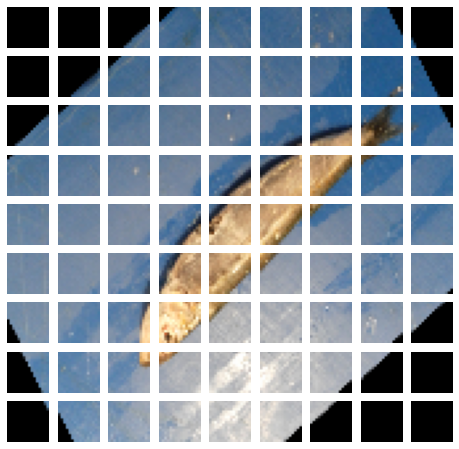

In [9]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (16, 16, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

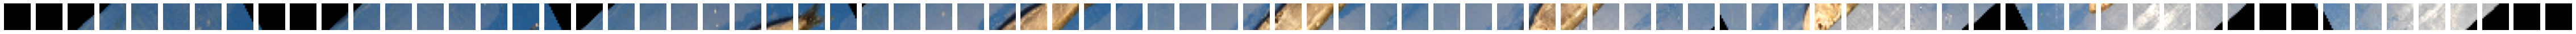

In [10]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(n *n , 1))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(1 ,n*n , i + 1)
    patch_img = tf.reshape(patch, (16, 16, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

# PatchEmbedding

In [11]:
class PatchEmbedding(tf.keras.layers.Layer):
  def __init__(self , size , num_of_patches , projection_dim):
    super().__init__()

    self.size=size
    self.num_of_patches= num_of_patches + 1
    self.projection_dim=projection_dim

    self.projection=tf.keras.layers.Dense(projection_dim)

    self.clsToken= tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , 1 , projection_dim)) , trainable=True)
    #create vector for each patch 
    self.positionalEmbedding = tf.keras.layers.Embedding(self.num_of_patches , projection_dim)


  def call(self, inputs):
    patches = tf.image.extract_patches(inputs , sizes=[1 , self.size , self.size , 1], strides=[1 , self.size , self.size , 1], rates=[1 ,1 ,1 ,1], padding="VALID",)
    patches=tf.reshape(patches, (tf.shape(inputs)[0], -1, self.size * self.size *3))
    patches= self.projection(patches)

    # repeat cls token length of batch size
    clsToken = tf.repeat(self.clsToken , tf.shape(inputs)[0] , 0)
    patches = tf.concat((clsToken, patches) , axis=1)
    # create position number for each patch
    positions = tf.range(0 , self.num_of_patches , 1)[tf.newaxis , ...]
    positionalEmbedding = self.positionalEmbedding(positions)

    #print(positionalEmbedding)
    patches= patches + positionalEmbedding
    return patches

# Transformer Layer





In [12]:
class TransformerLayer(tf.keras.layers.Layer):
  def __init__(self , d_model , heads , mlp_rate , dropout_rate=0.1):
    super().__init__()

    self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.mha= tf.keras.layers.MultiHeadAttention(heads, d_model//heads , dropout=dropout_rate)

    self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.mlp = tf.keras.Sequential([
                                    tf.keras.layers.Dense(d_model * mlp_rate , activation="gelu"),
                                    tf.keras.layers.Dropout(dropout_rate),
                                    tf.keras.layers.Dense(d_model , activation="gelu"),
                                    tf.keras.layers.Dropout(dropout_rate)
    ])
  def call(self , inputs , training=True):
    out_1 = self.layernorm_1(inputs)
    out_1 = self.mha(out_1 , out_1 ,training=training)
    out_1 = inputs + out_1

    out_2= self.layernorm_2(out_1)
    out_2=self.mlp(out_2 , training=training)
    out_2 = out_1 + out_2

    return out_2


# Transformer Encoder

In [13]:
class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self , d_model , heads , mlp_rate , num_layers=1 , dropout_rate=0.1):
    super().__init__()

    self.encoders = [TransformerLayer(d_model , heads , mlp_rate , dropout_rate) for _ in range(num_layers)]

  def call(self , inputs , training=True):
    x =inputs

    for layer in self.encoders:
      x = layer(x , training=training)

    return x

# Vision Transformer

In [14]:
class ViT(tf.keras.Model):
  def __init__(self , num_classes , patch_size , num_of_patches , d_model , heads , num_layers , mlp_rate , dropout_rate=0.1):
    super().__init__()

    self.patchEmbedding = PatchEmbedding(patch_size , num_of_patches , d_model)
    self.encoder = TransformerEncoder(d_model , heads , mlp_rate  ,num_layers , dropout_rate)

    self.prediction = tf.keras.Sequential([
                                           tf.keras.layers.Dropout(0.3),
                                           tf.keras.layers.Dense(mlp_rate * d_model , activation="gelu"),
                                           tf.keras.layers.Dropout(0.2),       
                                           tf.keras.layers.Dense(num_classes, activation="softmax")

                                           
  ])
  def call(self , inputs ,  training=True):
    patches = self.patchEmbedding(inputs)
    encoderResult = self.encoder(patches, training=training)

    clsResult = encoderResult[: , 0 , :]

    prediction = self.prediction(clsResult,
                                 training=training)
    return prediction

# prepare dataset

In [15]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [16]:

image_size=72
preprocessingModel = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.Normalization(),
        tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size),
    ]
)
# Compute the mean and the variance of the training data for normalization.
preprocessingModel.layers[0].adapt(x_train)

augmentationModel = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)


In [17]:
def convert_to_dataset(data, batch_size, shuffle=False , augment=False):
  dataset = tf.data.Dataset.from_tensor_slices(data)
  dataset = dataset.map(lambda x , y: (preprocessingModel(x) [0] , y) , num_parallel_calls=tf.data.AUTOTUNE)

  if shuffle:
    dataset= dataset.shuffle(len(dataset))

  dataset = dataset.batch(batch_size , drop_remainder=True)

  if augment:
    dataset = dataset.map(lambda x , y: (augmentationModel(x , training=True) , y) , num_parallel_calls=tf.data.AUTOTUNE)

  return dataset.prefetch(tf.data.AUTOTUNE)


In [18]:
trainingData = convert_to_dataset((x_train , y_train) , 1024 , shuffle=True , augment=True)
valData = convert_to_dataset((x_test , y_test) , 1024 , shuffle=False , augment=False)

print(trainingData)
print(valData)

<PrefetchDataset shapes: ((1024, 72, 72, 3), (1024, 1)), types: (tf.float32, tf.uint8)>
<PrefetchDataset shapes: ((1024, 72, 72, 3), (1024, 1)), types: (tf.float32, tf.uint8)>


# model

In [19]:

vitClassifier = ViT(
                10,
                6,
                (72//6)**2,
                128,
                2,
                4,
                2,
                0.1
)

vitClassifier.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=[
      tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
      tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
  ],
)

In [20]:
history = vitClassifier.fit(trainingData , batch_size=1024 , validation_data=valData , epochs=60)

2022-04-05 09:41:46.304112: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-05 09:41:46.311297: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/60


2022-04-05 09:41:50.454762: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-04-05 09:41:51.306040: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-04-05 09:42:00.427356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33644 of 50000
2022-04-05 09:42:05.310072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 70s 1s/step - loss: 2.1652 - accuracy: 0.2133 - top-5-accuracy: 0.7181 - val_loss: 1.7008 - val_accuracy: 0.3641 - val_top-5-accuracy: 0.8771
Epoch 2/60


2022-04-05 09:43:06.708544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41162 of 50000
2022-04-05 09:43:09.673957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 1.7316 - accuracy: 0.3546 - top-5-accuracy: 0.8699 - val_loss: 1.5792 - val_accuracy: 0.4239 - val_top-5-accuracy: 0.8972
Epoch 3/60


2022-04-05 09:44:09.851354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 40776 of 50000
2022-04-05 09:44:12.507040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 1.5869 - accuracy: 0.4190 - top-5-accuracy: 0.9001 - val_loss: 1.3827 - val_accuracy: 0.4954 - val_top-5-accuracy: 0.9313
Epoch 4/60


2022-04-05 09:45:13.566807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 39064 of 50000
2022-04-05 09:45:16.328635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 1.4314 - accuracy: 0.4764 - top-5-accuracy: 0.9273 - val_loss: 1.2788 - val_accuracy: 0.5344 - val_top-5-accuracy: 0.9440
Epoch 5/60


2022-04-05 09:46:16.856813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41118 of 50000
2022-04-05 09:46:19.108360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 1.3323 - accuracy: 0.5147 - top-5-accuracy: 0.9412 - val_loss: 1.2056 - val_accuracy: 0.5613 - val_top-5-accuracy: 0.9533
Epoch 6/60


2022-04-05 09:47:20.117189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41103 of 50000
2022-04-05 09:47:22.364818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 62s 1s/step - loss: 1.2608 - accuracy: 0.5440 - top-5-accuracy: 0.9471 - val_loss: 1.1595 - val_accuracy: 0.5768 - val_top-5-accuracy: 0.9561
Epoch 7/60


2022-04-05 09:48:22.679101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 40570 of 50000
2022-04-05 09:48:25.399341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 1.1950 - accuracy: 0.5713 - top-5-accuracy: 0.9523 - val_loss: 1.1202 - val_accuracy: 0.5955 - val_top-5-accuracy: 0.9619
Epoch 8/60


2022-04-05 09:49:26.026079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 40980 of 50000
2022-04-05 09:49:28.300936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 62s 1s/step - loss: 1.1376 - accuracy: 0.5904 - top-5-accuracy: 0.9597 - val_loss: 1.0751 - val_accuracy: 0.6086 - val_top-5-accuracy: 0.9659
Epoch 9/60


2022-04-05 09:50:28.401806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 40721 of 50000
2022-04-05 09:50:30.737957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 1.1140 - accuracy: 0.5997 - top-5-accuracy: 0.9614 - val_loss: 1.0115 - val_accuracy: 0.6365 - val_top-5-accuracy: 0.9679
Epoch 10/60


2022-04-05 09:51:31.719160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41054 of 50000
2022-04-05 09:51:34.125673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 1.0873 - accuracy: 0.6127 - top-5-accuracy: 0.9647 - val_loss: 0.9809 - val_accuracy: 0.6439 - val_top-5-accuracy: 0.9727
Epoch 11/60


2022-04-05 09:52:34.589183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 39595 of 50000
2022-04-05 09:52:37.405936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 1.0380 - accuracy: 0.6285 - top-5-accuracy: 0.9661 - val_loss: 0.9857 - val_accuracy: 0.6507 - val_top-5-accuracy: 0.9716
Epoch 12/60


2022-04-05 09:53:38.563494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 40991 of 50000
2022-04-05 09:53:40.740000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 62s 1s/step - loss: 1.0151 - accuracy: 0.6406 - top-5-accuracy: 0.9674 - val_loss: 0.9515 - val_accuracy: 0.6634 - val_top-5-accuracy: 0.9721
Epoch 13/60


2022-04-05 09:54:41.213971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41453 of 50000
2022-04-05 09:54:43.246235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.9947 - accuracy: 0.6468 - top-5-accuracy: 0.9697 - val_loss: 0.9467 - val_accuracy: 0.6649 - val_top-5-accuracy: 0.9711
Epoch 14/60


2022-04-05 09:55:44.385653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41717 of 50000
2022-04-05 09:55:46.790954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.9650 - accuracy: 0.6576 - top-5-accuracy: 0.9708 - val_loss: 0.8947 - val_accuracy: 0.6798 - val_top-5-accuracy: 0.9753
Epoch 15/60


2022-04-05 09:56:47.505215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41300 of 50000
2022-04-05 09:56:49.566499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.9405 - accuracy: 0.6673 - top-5-accuracy: 0.9738 - val_loss: 0.8848 - val_accuracy: 0.6815 - val_top-5-accuracy: 0.9773
Epoch 16/60


2022-04-05 09:57:50.399853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 40078 of 50000
2022-04-05 09:57:52.788879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.9244 - accuracy: 0.6762 - top-5-accuracy: 0.9743 - val_loss: 0.9118 - val_accuracy: 0.6760 - val_top-5-accuracy: 0.9774
Epoch 17/60


2022-04-05 09:58:53.108867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38227 of 50000
2022-04-05 09:58:55.937596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.9054 - accuracy: 0.6787 - top-5-accuracy: 0.9746 - val_loss: 0.8727 - val_accuracy: 0.6867 - val_top-5-accuracy: 0.9773
Epoch 18/60


2022-04-05 09:59:56.901029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 40050 of 50000
2022-04-05 09:59:59.614200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.8966 - accuracy: 0.6846 - top-5-accuracy: 0.9764 - val_loss: 0.8876 - val_accuracy: 0.6903 - val_top-5-accuracy: 0.9782
Epoch 19/60


2022-04-05 10:01:00.078505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38087 of 50000
2022-04-05 10:01:02.958809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.8655 - accuracy: 0.6931 - top-5-accuracy: 0.9777 - val_loss: 0.8483 - val_accuracy: 0.7023 - val_top-5-accuracy: 0.9803
Epoch 20/60


2022-04-05 10:02:03.414934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38101 of 50000
2022-04-05 10:02:06.295826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.8616 - accuracy: 0.6956 - top-5-accuracy: 0.9776 - val_loss: 0.8317 - val_accuracy: 0.7095 - val_top-5-accuracy: 0.9797
Epoch 21/60


2022-04-05 10:03:06.768176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38738 of 50000
2022-04-05 10:03:09.428674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.8250 - accuracy: 0.7078 - top-5-accuracy: 0.9795 - val_loss: 0.8327 - val_accuracy: 0.7091 - val_top-5-accuracy: 0.9793
Epoch 22/60


2022-04-05 10:04:09.619266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38360 of 50000
2022-04-05 10:04:12.771832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.8157 - accuracy: 0.7104 - top-5-accuracy: 0.9804 - val_loss: 0.8065 - val_accuracy: 0.7181 - val_top-5-accuracy: 0.9836
Epoch 23/60


2022-04-05 10:05:13.081275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38427 of 50000
2022-04-05 10:05:15.885158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.7982 - accuracy: 0.7223 - top-5-accuracy: 0.9805 - val_loss: 0.8508 - val_accuracy: 0.7059 - val_top-5-accuracy: 0.9785
Epoch 24/60


2022-04-05 10:06:17.017350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38822 of 50000
2022-04-05 10:06:19.644957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.7974 - accuracy: 0.7202 - top-5-accuracy: 0.9813 - val_loss: 0.8142 - val_accuracy: 0.7182 - val_top-5-accuracy: 0.9794
Epoch 25/60


2022-04-05 10:07:20.210123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 39227 of 50000
2022-04-05 10:07:23.405555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.7893 - accuracy: 0.7205 - top-5-accuracy: 0.9822 - val_loss: 0.8030 - val_accuracy: 0.7201 - val_top-5-accuracy: 0.9826
Epoch 26/60


2022-04-05 10:08:24.226746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41233 of 50000
2022-04-05 10:08:26.891040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 62s 1s/step - loss: 0.7759 - accuracy: 0.7267 - top-5-accuracy: 0.9830 - val_loss: 0.7799 - val_accuracy: 0.7271 - val_top-5-accuracy: 0.9829
Epoch 27/60


2022-04-05 10:09:26.845487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 39586 of 50000
2022-04-05 10:09:30.097047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.7616 - accuracy: 0.7347 - top-5-accuracy: 0.9824 - val_loss: 0.7957 - val_accuracy: 0.7216 - val_top-5-accuracy: 0.9809
Epoch 28/60


2022-04-05 10:10:30.363609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41115 of 50000
2022-04-05 10:10:32.467648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.7485 - accuracy: 0.7381 - top-5-accuracy: 0.9824 - val_loss: 0.8024 - val_accuracy: 0.7237 - val_top-5-accuracy: 0.9817
Epoch 29/60


2022-04-05 10:11:33.425588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41220 of 50000
2022-04-05 10:11:35.562568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.7381 - accuracy: 0.7411 - top-5-accuracy: 0.9847 - val_loss: 0.7513 - val_accuracy: 0.7420 - val_top-5-accuracy: 0.9839
Epoch 30/60


2022-04-05 10:12:36.578175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41346 of 50000
2022-04-05 10:12:38.732366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.7078 - accuracy: 0.7517 - top-5-accuracy: 0.9850 - val_loss: 0.7270 - val_accuracy: 0.7466 - val_top-5-accuracy: 0.9846
Epoch 31/60


2022-04-05 10:13:40.419918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 40726 of 50000
2022-04-05 10:13:42.897548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.7122 - accuracy: 0.7479 - top-5-accuracy: 0.9855 - val_loss: 0.7248 - val_accuracy: 0.7472 - val_top-5-accuracy: 0.9843
Epoch 32/60


2022-04-05 10:14:44.073276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41416 of 50000
2022-04-05 10:14:46.122423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.7066 - accuracy: 0.7530 - top-5-accuracy: 0.9857 - val_loss: 0.7776 - val_accuracy: 0.7275 - val_top-5-accuracy: 0.9829
Epoch 33/60


2022-04-05 10:15:47.868313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 39689 of 50000
2022-04-05 10:15:50.390458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.6962 - accuracy: 0.7572 - top-5-accuracy: 0.9856 - val_loss: 0.7487 - val_accuracy: 0.7434 - val_top-5-accuracy: 0.9862
Epoch 34/60


2022-04-05 10:16:51.706380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 40595 of 50000
2022-04-05 10:16:53.967854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.6860 - accuracy: 0.7608 - top-5-accuracy: 0.9869 - val_loss: 0.7479 - val_accuracy: 0.7459 - val_top-5-accuracy: 0.9860
Epoch 35/60


2022-04-05 10:17:55.881144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 40248 of 50000
2022-04-05 10:17:58.274840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.6668 - accuracy: 0.7642 - top-5-accuracy: 0.9885 - val_loss: 0.7138 - val_accuracy: 0.7555 - val_top-5-accuracy: 0.9855
Epoch 36/60


2022-04-05 10:18:59.534910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 39976 of 50000
2022-04-05 10:19:02.367371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.6595 - accuracy: 0.7663 - top-5-accuracy: 0.9880 - val_loss: 0.7179 - val_accuracy: 0.7563 - val_top-5-accuracy: 0.9847
Epoch 37/60


2022-04-05 10:20:04.192480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41572 of 50000
2022-04-05 10:20:06.209837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.6456 - accuracy: 0.7729 - top-5-accuracy: 0.9888 - val_loss: 0.7172 - val_accuracy: 0.7591 - val_top-5-accuracy: 0.9852
Epoch 38/60


2022-04-05 10:21:07.832533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41848 of 50000
2022-04-05 10:21:09.729026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.6317 - accuracy: 0.7775 - top-5-accuracy: 0.9886 - val_loss: 0.7831 - val_accuracy: 0.7367 - val_top-5-accuracy: 0.9837
Epoch 39/60


2022-04-05 10:22:11.500730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41617 of 50000
2022-04-05 10:22:13.489121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.6396 - accuracy: 0.7724 - top-5-accuracy: 0.9889 - val_loss: 0.7022 - val_accuracy: 0.7604 - val_top-5-accuracy: 0.9872
Epoch 40/60


2022-04-05 10:23:15.814150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 39815 of 50000
2022-04-05 10:23:18.232267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.6367 - accuracy: 0.7770 - top-5-accuracy: 0.9888 - val_loss: 0.6984 - val_accuracy: 0.7607 - val_top-5-accuracy: 0.9858
Epoch 41/60


2022-04-05 10:24:20.159101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 42871 of 50000
2022-04-05 10:24:22.100114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.6288 - accuracy: 0.7798 - top-5-accuracy: 0.9894 - val_loss: 0.7041 - val_accuracy: 0.7597 - val_top-5-accuracy: 0.9871
Epoch 42/60


2022-04-05 10:25:23.902396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 40226 of 50000
2022-04-05 10:25:26.437133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.6203 - accuracy: 0.7815 - top-5-accuracy: 0.9902 - val_loss: 0.7010 - val_accuracy: 0.7625 - val_top-5-accuracy: 0.9861
Epoch 43/60


2022-04-05 10:26:27.613677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 39689 of 50000
2022-04-05 10:26:30.132429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.6003 - accuracy: 0.7875 - top-5-accuracy: 0.9897 - val_loss: 0.6820 - val_accuracy: 0.7679 - val_top-5-accuracy: 0.9862
Epoch 44/60


2022-04-05 10:27:30.522764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38884 of 50000
2022-04-05 10:27:33.139690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.5964 - accuracy: 0.7891 - top-5-accuracy: 0.9903 - val_loss: 0.7064 - val_accuracy: 0.7592 - val_top-5-accuracy: 0.9870
Epoch 45/60


2022-04-05 10:28:33.713146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38790 of 50000
2022-04-05 10:28:36.387908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.5819 - accuracy: 0.7963 - top-5-accuracy: 0.9902 - val_loss: 0.6815 - val_accuracy: 0.7726 - val_top-5-accuracy: 0.9864
Epoch 46/60


2022-04-05 10:29:37.301291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38720 of 50000
2022-04-05 10:29:40.463706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.5735 - accuracy: 0.8002 - top-5-accuracy: 0.9917 - val_loss: 0.6777 - val_accuracy: 0.7750 - val_top-5-accuracy: 0.9873
Epoch 47/60


2022-04-05 10:30:41.311213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37869 of 50000
2022-04-05 10:30:44.267549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.5662 - accuracy: 0.8013 - top-5-accuracy: 0.9919 - val_loss: 0.6951 - val_accuracy: 0.7680 - val_top-5-accuracy: 0.9856
Epoch 48/60


2022-04-05 10:31:45.009415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38256 of 50000
2022-04-05 10:31:47.740056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.5637 - accuracy: 0.8006 - top-5-accuracy: 0.9915 - val_loss: 0.6864 - val_accuracy: 0.7697 - val_top-5-accuracy: 0.9863
Epoch 49/60


2022-04-05 10:32:48.675469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37566 of 50000
2022-04-05 10:32:51.689638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.5611 - accuracy: 0.8006 - top-5-accuracy: 0.9922 - val_loss: 0.7037 - val_accuracy: 0.7679 - val_top-5-accuracy: 0.9885
Epoch 50/60


2022-04-05 10:33:52.646755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36937 of 50000
2022-04-05 10:33:55.948627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.5421 - accuracy: 0.8086 - top-5-accuracy: 0.9919 - val_loss: 0.6445 - val_accuracy: 0.7820 - val_top-5-accuracy: 0.9885
Epoch 51/60


2022-04-05 10:34:57.056262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36805 of 50000
2022-04-05 10:35:00.551508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 65s 1s/step - loss: 0.5512 - accuracy: 0.8055 - top-5-accuracy: 0.9914 - val_loss: 0.6784 - val_accuracy: 0.7694 - val_top-5-accuracy: 0.9874
Epoch 52/60


2022-04-05 10:36:02.422055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38031 of 50000
2022-04-05 10:36:05.626612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.5432 - accuracy: 0.8088 - top-5-accuracy: 0.9923 - val_loss: 0.6711 - val_accuracy: 0.7772 - val_top-5-accuracy: 0.9875
Epoch 53/60


2022-04-05 10:37:06.565103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38161 of 50000
2022-04-05 10:37:09.434103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.5305 - accuracy: 0.8123 - top-5-accuracy: 0.9937 - val_loss: 0.6837 - val_accuracy: 0.7718 - val_top-5-accuracy: 0.9874
Epoch 54/60


2022-04-05 10:38:10.735471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38760 of 50000
2022-04-05 10:38:13.367440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.5312 - accuracy: 0.8129 - top-5-accuracy: 0.9933 - val_loss: 0.6737 - val_accuracy: 0.7744 - val_top-5-accuracy: 0.9872
Epoch 55/60


2022-04-05 10:39:14.711211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38156 of 50000
2022-04-05 10:39:17.778123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.5183 - accuracy: 0.8159 - top-5-accuracy: 0.9927 - val_loss: 0.6744 - val_accuracy: 0.7759 - val_top-5-accuracy: 0.9878
Epoch 56/60


2022-04-05 10:40:18.727597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41119 of 50000
2022-04-05 10:40:21.459478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 63s 1s/step - loss: 0.5264 - accuracy: 0.8137 - top-5-accuracy: 0.9930 - val_loss: 0.6639 - val_accuracy: 0.7827 - val_top-5-accuracy: 0.9883
Epoch 57/60


2022-04-05 10:41:22.539783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38051 of 50000
2022-04-05 10:41:26.438588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.5031 - accuracy: 0.8209 - top-5-accuracy: 0.9940 - val_loss: 0.6975 - val_accuracy: 0.7732 - val_top-5-accuracy: 0.9876
Epoch 58/60


2022-04-05 10:42:27.051062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41515 of 50000
2022-04-05 10:42:30.870516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.5091 - accuracy: 0.8205 - top-5-accuracy: 0.9931 - val_loss: 0.7071 - val_accuracy: 0.7677 - val_top-5-accuracy: 0.9872
Epoch 59/60


2022-04-05 10:43:31.041307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 40796 of 50000
2022-04-05 10:43:33.358136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.4956 - accuracy: 0.8240 - top-5-accuracy: 0.9937 - val_loss: 0.6766 - val_accuracy: 0.7770 - val_top-5-accuracy: 0.9891
Epoch 60/60


2022-04-05 10:44:35.298545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 41168 of 50000
2022-04-05 10:44:37.394976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


48/48 [==============================] - 64s 1s/step - loss: 0.5029 - accuracy: 0.8251 - top-5-accuracy: 0.9930 - val_loss: 0.6701 - val_accuracy: 0.7831 - val_top-5-accuracy: 0.9890


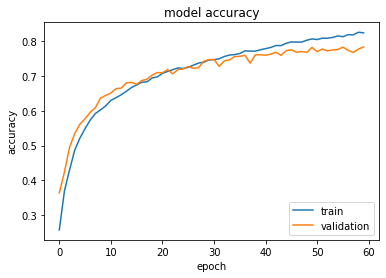

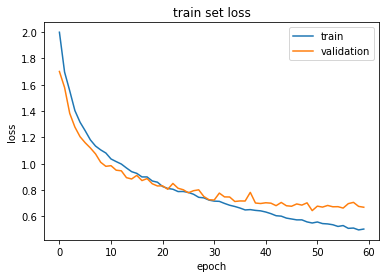

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Test

In [22]:
_, accuracy, top_5_accuracy = vitClassifier.evaluate(valData)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

9/9 [==============================] - 4s 401ms/step - loss: 0.6701 - accuracy: 0.7831 - top-5-accuracy: 0.9890
Test accuracy: 78.31%
Test top 5 accuracy: 98.9%
